In [1036]:
import chess
import chess.uci
import chess.pgn
import os
import csv
import matplotlib.pyplot as plt
from numpy import array
import numpy as np
import pandas as pd
import math
import ast
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline


In [1037]:
# if using raw evaluation data
def get_old_elo_perfs():
    game_data_path = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/game_data.pgn"
    eval_csv_path = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/stockfish_evals.csv"

    pgns = open(game_data_path)
    eval_csv = open(eval_csv_path)

    sf_evals_csv = csv.reader(eval_csv, delimiter=',')

    evals = []
    for item in sf_evals_csv:
        item.pop(0)
        item = str(item)[2:-2].split()
        evals.append(item)
    evals.pop(0)
    
    elo_and_performance = []

    for i in range(49000):
        pw = []
        pb = []
        current_game = chess.pgn.read_game(pgns)
        try:
            pw.append(float(current_game.headers["WhiteElo"]))
        except:
            pw.append(0.0)
        try:
            pb.append(float(current_game.headers["BlackElo"]))
        except:
            pb.append(0.0)
        try:
            pw.append(float(evals[i][0]))
        except:
            pw.append(0.0)
        for j in range (len(evals[i])):
            if j == 0:
                continue
            try:
                move_value = float(evals[i][j]) - float(evals[i][j-1])
            except:
                move_value = 0.0
            if j % 2 != 0: 
                pb.append(-move_value)
            else:
                pw.append(move_value)
        elo_and_performance.append(pw)
        elo_and_performance.append(pb)

    elo_and_performance = array(elo_and_performance)
    
    
    return elo_and_performance
    

In [1038]:
# # straight from kaggle dataset
# elo_and_performance = []

# for i in range(49000):
#     pw = []
#     pb = []
#     current_game = chess.pgn.read_game(pgns)
#     try:
#         pw.append(float(current_game.headers["WhiteElo"]))
#     except:
#         pw.append(0.0)
#     try:
#         pb.append(float(current_game.headers["BlackElo"]))
#     except:
#         pb.append(0.0)
#     try:
#         pw.append(float(evals[i][0]))
#     except:
#         pw.append(0.0)
#     for j in range (len(evals[i])):
#         if j == 0:
#             continue
#         try:
#             move_value = float(evals[i][j]) - float(evals[i][j-1])
#         except:
#             move_value = 0.0
#         if j % 2 != 0: 
#             pb.append(-move_value)
#         else:
#             pw.append(move_value)
#     elo_and_performance.append(pw)
#     elo_and_performance.append(pb)

# elo_and_performance = array(elo_and_performance)



In [1039]:
# if using my own stockfish analysis
def get_new_elo_perfs(eval_time): 

    assert type(eval_time) is float, "Eval_time is not a float: %r" % name

    time_str = "def"

    if eval_time == 0.5:
        time_str = "halfsecond"
    if eval_time == 1.0:
        time_str = "onesecond"
    if eval_time == 3.0:
        time_str = "threeseconds"

    if time_str == "def":
        print("Eval time not available")
        return null


    elo_and_p = []
    performances_file = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/stockfish_performances_" + time_str + ".txt"

    with open(performances_file, 'r') as f:
        for line in f:
            listobj = ast.literal_eval(line)
            elo_and_p.append(listobj)
            
    #removing openings for now
    for item in elo_and_p:
        del item[1]
    
    #inserting win/loss from separate extraction
    winloss = []
    winloss_file_dir = "/Users/tylerahlstrom/Documents/GitHub/DI_proposal/data/winloss.txt"
    winloss_file = open(winloss_file_dir)
    filecontents = winloss_file.readlines()
    for line in filecontents:
        target_content = line.strip('\n')
        winloss.append(target_content)
        
    for i in range(len(elo_and_p)):
        elo_and_p[i].insert(1,winloss[i])
    
    
    return elo_and_p

In [1040]:
def remove_bugged_evals(provided_list):

    zero_rows = []
    i = 0
    for row in provided_list: 
        i+=1
        if row.count(0.0)>3:
            zero_rows.append(i)
    if (len(zero_rows) > 1):
        print("Found many zeros in these rows: " + str(zero_rows[1:40]))
        new_perf = [row for row in provided_list if row.count(0.0) < 2]
        new_perf = [row for row in new_perf if row[0] > 1]
        print("...and removed those rows")
    else:
        print("List is cleared of zeros bug")
        new_perf = provided_list
    return new_perf


In [1041]:
def remove_short_games(provided_list):

    threshold = 12
    
    nomove_rows = []
    i = 0
    for row in provided_list:
        if len(row) < threshold:
            nomove_rows.append(i)
        i+=1
    if (len(nomove_rows) > 0):
        print("Found less than 3 moves these rows: " + str(nomove_rows[:]))
        new_list = [row for row in provided_list if len(row) >= threshold]
        print("...and removed those rows")
    else:
        print("List has no short games")
        new_list = provided_list
    return new_list

### Get data and clean it:

In [1042]:
elo_and_performance = get_new_elo_perfs(3.0)

elo_and_performance = elo_and_performance[:1000]
print("Data points before clean-up: " + str(len(elo_and_performance)))
elo_and_performance = remove_bugged_evals(elo_and_performance)
elo_and_performance = remove_short_games(elo_and_performance)
print("Data points after clean-up: " + str(len(elo_and_performance)))
print(elo_and_performance[0:2])


Data points before clean-up: 1000
List is cleared of zeros bug
Found less than 3 moves these rows: [10, 11, 122, 123, 166, 167, 194, 195, 246, 247, 312, 313, 324, 325, 330, 331, 339, 388, 389, 394, 395, 396, 397, 424, 425, 452, 453, 584, 585, 612, 613, 644, 645, 796, 797, 814, 815, 822, 823, 881]
...and removed those rows
Data points after clean-up: 960
[['1833', '0.0', '-28.00', '-25.00', '-18.00', '-27.00', '-16.00', '-54.00', '-84.00', '-39.00', '-29.00', '-50.00', '-158.00', '-38.00', '16.00', '-93.00', '-187.00', '-182.00', '-350.00', '-141.00', '-933.00'], ['1799', '1.0', '-61.00', '-18.00', '-27.00', '-15.00', '-57.00', '-45.00', '-30.00', '-231.00', '-53.00', '-5.00', '-43.00', '-249.00', '-79.00', '-136.00', '-23.00', '-143.00', '-55.00', '40.00', '-32.00']]


### Create features:

In [1043]:
data_points = []

for item in elo_and_performance:
    dp = []
    
    #0
    dp.append(int(item[0]))
    
    #1
    dp.append(float(item[1]))

    
    arr = np.array([float(entry) for entry in item[2:]], dtype = float)
    
    average = np.mean(arr)
    #2
    dp.append(average)
    #dp.append(np.square(average))
    
    std = np.std(arr)
    #3
    dp.append(std)
    #dp.append(np.square(std))


    ten_ave = np.mean(arr[0:9])
    #4
    dp.append(ten_ave)
    #dp.append(np.square(ten_ave))

    
    std_ten = np.std(arr[0:9])
    #5
    dp.append(std_ten) 
    #dp.append(np.square(std_ten))

    
    #6
    dp.append(len(item))
    #dp.append(np.square(len(item)))

    
#    arr = np.sort(arr)
#    ave_five_worst = np.mean(arr[0:4])
    #ave_ten_worst = np.mean(arr[0:9])
    

    #7
#    dp.append(ave_five_worst)
#    dp.append(np.square(ave_five_worst))

    #8
#    dp.append(ave_ten_worst)
#    dp.append(np.square(ave_ten_worst))

#    dp.append(np.sum(arr[0:4]))
#    dp.append(np.sum(arr[0:9]))

    #print(arr)
    
    data_points.append(dp)

data_points = array(data_points)
np.set_printoptions(suppress=True)

#np.random.shuffle(data_points)
print(data_points.shape)
print(data_points[0:10])

(960, 7)
[[1833.            0.         -128.21052632  207.93561224  -35.55555556
    20.20512097   21.        ]
 [1799.            1.          -66.42105263   72.09592717  -59.66666667
    62.62942156   21.        ]
 [1708.            1.          -49.66666667   47.27725551  -41.33333333
    25.09094569   26.        ]
 [1556.            0.          -56.69565217   38.18539988  -41.
    12.6578917    25.        ]
 [1811.            1.          -88.7         118.19366875  -93.55555556
   118.68268722   32.        ]
 [1790.            0.         -120.17241379  140.72327185  -82.22222222
    81.8260727    31.        ]
 [1459.            0.         -104.17948718  209.62162149 -128.55555556
   238.66718394   41.        ]
 [1240.            1.         -254.57894737  818.72640606  -94.77777778
   121.04340615   40.        ]
 [1852.            0.5         -66.2         108.30660183  -50.11111111
    33.11073825   27.        ]
 [1852.            0.5        -152.5         248.42621306  -55.77777778


### Create training and test set:

In [1044]:
test_percentage = 5
total = len(data_points)
train_size = int(total * (100-test_percentage)/100)


X_train = data_points[:train_size,1:]

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
print(X_train[3])

Y_train_elo = data_points[:train_size,0]
Y_train_wl = data_points[:train_size,1]



X_test = data_points[train_size:,1:]

X_test = scaler.transform(X_test)

Y_test_elo = data_points[train_size:,0]
Y_test_wl = data_points[train_size:,1]

print ("X_train: " + str(X_train.shape))
print ("X_test: " + str(X_test.shape))
print ("Y_train: " + str(Y_train_elo.shape))
print ("Y_test: " + str(Y_test_elo.shape))

[-1.02150784  0.68200788 -0.78587075  0.53967415 -0.67568164 -0.59063629]
X_train: (912, 6)
X_test: (48, 6)
Y_train: (912,)
Y_test: (48,)


### Build models:

In [1045]:
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve


In [1046]:
model = MLPRegressor(hidden_layer_sizes=(2,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.00000001,
        alpha=0.01,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [1047]:
model1 = MLPRegressor(hidden_layer_sizes=(4,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.000001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [1048]:
model2 = MLPRegressor(hidden_layer_sizes=(6,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=1000000,
        #learning_rate_init=0.001,
        tol = 0.00000001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)

In [1049]:
model3 = MLPRegressor(hidden_layer_sizes=(8,),
        activation='relu',
        solver='lbfgs',
        #learning_rate='adaptive',
        max_iter=100000,
        #learning_rate_init=0.001,
        tol = 0.00001,
        alpha=0.00001,
        #early_stopping=False,
        #shuffle=True,
        warm_start=True,
        random_state = 0)


### Train and test models:

In [1050]:
model.fit(X_train, Y_train_elo)
Y_pred = model.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model.score(X_test, Y_test_elo)))

Average absolute error: 243.19131394538093
Training set r^2: 0.16572316264268405
Test set r^2: 0.260564968421126


In [1051]:
model1.fit(X_train, Y_train_elo)
Y_pred = model1.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model1.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model1.score(X_test, Y_test_elo)))

Average absolute error: 257.830872675359
Training set r^2: 0.2103777582293892
Test set r^2: 0.16886084839187085


In [1052]:
model2.fit(X_train, Y_train_elo)
Y_pred = model2.predict(X_test)
print("Average absolute error: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))
print("Training set r^2: " + str(model2.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model2.score(X_test, Y_test_elo)))

Average absolute error: 278.40978962486554
Training set r^2: 0.24959959150878264
Test set r^2: 0.030890372974026525


In [1053]:
model3.fit(X_train, Y_train_elo)
Y_pred = model3.predict(X_test)
Y2_pred = model3.predict(X_train)
print("Average absolute error train: " + str(math.sqrt(mean_squared_error(Y_train_elo, Y2_pred))))
print("Average absolute error test: " + str(math.sqrt(mean_squared_error(Y_test_elo, Y_pred))))

print("Training set r^2: " + str(model3.score(X_train, Y_train_elo)))
print("Test set r^2: " + str(model3.score(X_test, Y_test_elo)))

# loss_values = model3.loss_curve_
# plt.plot(loss_values)
# plt.show()

# train_sizes, train_scores, test_scores = learning_curve(model3, X, Y, n_jobs=-1, cv=cv, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure()
# plt.title("RandomForestClassifier")
# plt.legend(loc="best")
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.gca().invert_yaxis()

# # box-like grid
# plt.grid()

# # plot the std deviation as a transparent range at each training set size
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# # plot the average training and test score lines at each training set size
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# # sizes the window for readability and displays the plot
# # shows error from 0 to 1.1
# #plt.ylim(-.1,1.1)
# plt.show()



Average absolute error train: 251.83622368617674
Average absolute error test: 258.38095300938073
Training set r^2: 0.22279887427838685
Test set r^2: 0.16531060627605232


In [1054]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train_elo)
Y_pred = regr.predict(X_test)
print(regr.coef_)
print(math.sqrt(mean_squared_error(Y_test_elo, Y_pred)))
print(r2_score(Y_test_elo, Y_pred))



[ -0.69623758  62.42484604  31.86000904  64.27987053 -10.24976729
  40.41794403]
273.45432490302784
0.06508205349020169


### Null test for predicting elo:

In [1055]:
average_elo = np.sum(Y_train_elo)/len(Y_train_elo)
print("average elo: " + str(average_elo))

l = len(Y_pred)
Y_pred = []
for i in range(l):
    Y_pred.append(average_elo)
print(math.sqrt(mean_squared_error(Y_test_elo, Y_pred)))
print(r2_score(Y_test_elo, Y_pred))


average elo: 1662.5427631578948
294.857362032756
-0.08699577250784318


### Run best model to predict win/loss:

In [1056]:
model1.fit(X_train, Y_train_wl)
Y_pred = model1.predict(X_test)
#print(model.coef_)
print(math.sqrt(mean_squared_error(Y_test_wl, Y_pred)))
print(model1.score(X_test, Y_test_wl)) 
print(r2_score(Y_test_wl, Y_pred))

0.45643546458763845
0.0
0.0


### Below lies messy graphing scripts

In [81]:
group_data = []

num_bins = 6

bins = np.linspace(1000, 2500, num_bins)

for bin in range (num_bins):
    group_data_point = []
    group_data_point.append(bins[bin])
    min=1000.0+(300*bin)
    group_count = 0
    group_mean = []
    group_std = []
    for point in data_points:
        if (point[0].item() > min) & (point[0].item() < min + 300):
            group_count +=1
            if not math.isnan(float(point[4])):
                group_mean.append(point[4])
            if not math.isnan(float(point[5])):
                group_std.append(point[5])
    group_mean = np.mean(array(group_mean))
    group_std = np.mean(array(group_std))

    if math.isnan(float(group_mean)):
        print(group_mean)
    if math.isnan(float(group_std)):
        print(group_std)

    group_data_point.append(group_mean)
    group_data_point.append(group_std)
    group_data.append(group_data_point)

binned_data = array(group_data)


In [82]:
%matplotlib qt

N = binned_data.shape[0]
print(N)
elos = [int(el[0]) for el in binned_data]
means = [el[1] for el in binned_data]
stds = [el[2] for el in binned_data]

print(elos)
print(means)
print(stds)



### scaling for viewing
means = [el*0.8 for el in means]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

ind = np.arange(N)  
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(ind, means, width, color='seagreen')
rects2 = ax.bar(ind + width*.8, stds, width, color='darkslateblue')


ax.set_ylabel('Values (scaled for viewing)')
ax.set_xlabel('Elo bins ')

ax.set_title('Features of evaluated moves')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(elos)

plt.tick_params(left='off', labelleft='off')

ax.legend((rects1[0], rects2[0]), ('Average move strength', 'Standard deviation of move strength'))


plt.axhline(0, color='black')
plt.show()

6
[1000, 1300, 1600, 1900, 2200, 2500]
[-86.35380116959062, -62.94311111111111, -53.484487734487736, -45.73099415204679, -40.52287581699346, -40.666666666666664]
[85.98396963256887, 52.792980730145125, 41.10757327963348, 27.620984040811702, 23.206707935333334, 14.70385119740566]


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [413]:
# x = data_points[:,0]
# y = [:,1]

data = np.array(data_points)

x = data[:,0]
y = data[:,13]
# x = np.array(x)
# y = np.array(y)

color = 'r'
scale = 1.0


#plt.legend()
plt.scatter(x,y, s=scale, c=color, marker = ",", lw=0, alpha = 0.5, label = 'accounts with # games played: <15')
#plt.scatter(x, y, c="g", alpha=0.5, marker=r'$\clubsuit$',label="Luck")
m, b = np.polyfit(x, y, 1)

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.plot(x, slope*x +intercept, '-', c = color, label = 'slope = ' + '%1.2E' % slope)
print("first order: " + str(np.power(r_value, 2)))

p = np.polyfit(x,y,2)
yfit = np.polyval(p,x)
yresid = y - yfit
SSresid = sum(np.power(yresid,2))
SStotal = (len(y)-1) * np.var(y)
rsq = 1 - SSresid/SStotal
print("second order: " + str(rsq))

p = np.polyfit(x,y,3)
yfit = np.polyval(p,x)
yresid = y - yfit
SSresid = sum(np.power(yresid,2))
SStotal = (len(y)-1) * np.var(y)
rsq = 1 - SSresid/SStotal
print("third order: " + str(rsq))

IndexError: index 13 is out of bounds for axis 1 with size 7

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


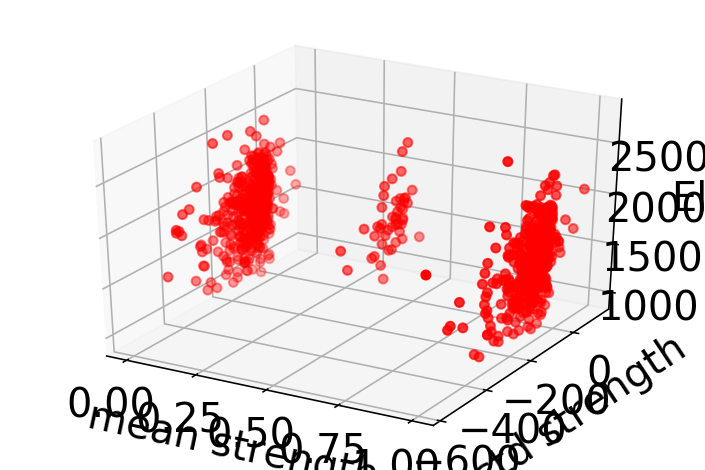

In [314]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c = 'r'
m = 'o'

xs = [(item[1]) for item in data_points]
ys = [(item[2]) for item in data_points]
zs = [(item[0]) for item in data_points]

ax.scatter(xs, ys, zs, c=c, marker=m)

# for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
#     xs = randrange(n, 23, 32)
#     ys = randrange(n, 0, 100)
#     zs = randrange(n, zlow, zhigh)

ax.set_xlabel('mean strength')
ax.set_ylabel('std strength')
ax.set_zlabel('Elo')

plt.show()